In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import itertools

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [3]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [10]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

sr_ab = '../'+config['sr']['ab']


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='mouse')[0]
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='mouse')[0]
m_read_annot = od+expand(config['lr']['talon']['full_annot'], species='mouse')[0]
m_t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='mouse')[0]
m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='mouse', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='mouse')[0]
m_major_isos = od+expand(config['lr']['analysis']['major_isos'], species='mouse', obs_col='sample')[0]
m_pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
m_pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='mouse')[0]


m_ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='mouse')[0]
m_ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='mouse')[0]


orth_table = '../../proc_revisions/ref/biomart_human_to_mouse.tsv'
mouse_ver = 'vM25_cerberus'

In [11]:
source = 'obs_major'

186


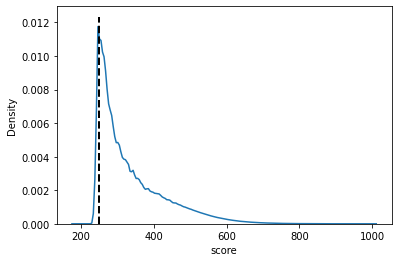

In [27]:
# read conserved elements in, threshold for a certain score
min_cons_score = 250
cons = pd.read_csv(phastcons, sep='\t', header=None,
                 names=['bin', 'Chromosome', 'Start', 'End', 'idk1', 'score'])
cons = cons[['Chromosome', 'Start', 'End', 'score']]
print(cons.score.min())
ax = sns.kdeplot(cons, x='score')
ylims = ax.get_ylim()
ax.vlines(min_cons_score, ylims[0], ylims[1],
                      colors='k', linestyles='dashed',
                      linewidth=2)
cons = cons.loc[cons.score >= min_cons_score]
cons = pr.PyRanges(cons)

In [28]:
# read gtf, limit to relevant columns
# only look at exons, calc exon len
gtf_df = pr.read_gtf(gtf, duplicate_attr=True).as_df()
gtf_df = gtf_df[['Chromosome', 'Start', 'End', 'gene_name',
                 'gene_id', 'transcript_id', 'Feature']]
gtf_df = gtf_df.loc[gtf_df.Feature=='exon']
gtf_df['exon_len'] = (gtf_df.Start-gtf_df.End).abs()

In [29]:
gtf_df = pr.PyRanges(gtf_df)
gtf_df = gtf_df.join(cons, report_overlap=True)

In [39]:
# ensure that phastcons things are non-overlapping
cons = cons.df
cons['region_id'] = cons.Chromosome.astype(str)+'_'+cons.Start.astype(str)+'_'+cons.End.astype(str)
cons = pr.PyRanges(cons)
temp = cons.join(cons)
temp.head()
temp = temp.df
assert len(temp.loc[temp.region_id!=temp.region_id_b]) == 0

In [42]:
gtf_df_back = gtf_df.df.copy(deep=True)

In [55]:
gtf_df = gtf_df.df

# get the total length of transcripts
temp = gtf_df[['gene_id', 'gene_name',
               'transcript_id', 'exon_len']].drop_duplicates().groupby(['gene_id',
                                                                        'gene_name',
                                                                        'transcript_id']).sum().reset_index().rename({'exon_len':'transcript_len'}, axis=1)

# get the total length of the conserved element
temp2 = gtf_df[['gene_id', 'gene_name',
                'transcript_id', 'Overlap']].groupby(['gene_id',
                                                      'gene_name',
                                                      'transcript_id']).sum().reset_index().rename({'Overlap':'cons_len'}, axis=1)
temp = temp.merge(temp2, how='left', on=['gene_id', 'gene_name', 'transcript_id'])

# # get conserved length in each transcript
# keep_cols = ['Chromosome', 'Start', 'End', 'gene_name', 'gene_id', 'transcript_id', 'Overlap']
# gb_cols = ['Chromosome', 'Start', 'End', 'gene_name', 'gene_id', 'transcript_id']
# temp = gtf_df[keep_cols]

# # get len covered in each transcript
# keep_cols = ['Chromosome', 'Start', 'End', 'gene_name', 'gene_id', 'transcript_id', 'exon_len', 'Overlap']
# gb_cols = ['Chromosome', 'Start', 'End', 'gene_name', 'gene_id', 'transcript_id']
# temp = gtf_df[keep_cols].groupby(gb_cols, observed=True).sum().reset_index().rename({'Overlap': 'cons_len',
#                                                                                      'exon_len': 'transcript_len'}, axis=1)
# temp.head()
temp.head()

,gene_id,gene_name,transcript_id,transcript_len,cons_len
0,ENSG00000000003.14,TSPAN6,"ENSG00000000003[1,1,1]",3868,1033
1,ENSG00000000003.14,TSPAN6,"ENSG00000000003[1,1,5]",2306,951
2,ENSG00000000003.14,TSPAN6,"ENSG00000000003[1,1,6]",3225,958
3,ENSG00000000003.14,TSPAN6,"ENSG00000000003[1,1,7]",2096,951
4,ENSG00000000003.14,TSPAN6,"ENSG00000000003[1,1,8]",1282,827


In [56]:
# get % exonic conservation per transcript
temp['perc_cons'] = (temp['cons_len']/temp['transcript_len'])*100

# get median % exonic conservation per gene across transcripts
temp = temp[['gene_name',
             'gene_id',
             'perc_cons']].groupby(['gene_name',
                                    'gene_id']).median().reset_index().rename({'perc_cons':'med_perc_cons'}, axis=1)

In [57]:
temp.head()

,gene_id,gene_name,transcript_id,transcript_len,cons_len,perc_cons
0,ENSG00000000003.14,TSPAN6,"ENSG00000000003[1,1,1]",3868,1033,26.706308
1,ENSG00000000003.14,TSPAN6,"ENSG00000000003[1,1,5]",2306,951,41.240243
2,ENSG00000000003.14,TSPAN6,"ENSG00000000003[1,1,6]",3225,958,29.705426
3,ENSG00000000003.14,TSPAN6,"ENSG00000000003[1,1,7]",2096,951,45.372137
4,ENSG00000000003.14,TSPAN6,"ENSG00000000003[1,1,8]",1282,827,64.508580


In [16]:
hm_gids = get_human_mouse_gid_table(orth_table)

# ca = cerberus.read(cerberus_h5)
# m_ca = cerberus.read(m_cerberus_h5)

# restrict sample triplets to mm ones
ca = cerberus.read(cerberus_h5)
samples = get_mouse_match_samples()
inds = ca.triplets.loc[(ca.triplets.source == 'sample_det')&\
                       ~(ca.triplets['sample'].isin(samples))].index
ca.triplets.drop(inds, axis=0, inplace=True)
ca.triplets.loc[ca.triplets.source == 'sample_det', 'source'] = 'sample_mm_det'
ca = get_centroids(ca, 
                   source='sample_mm_det',
                   gene_subset=gene_subset,
                   ver=ver)

# add suffix to mouse sources
m_ca = cerberus.read(m_cerberus_h5)
m_ca.triplets.loc[m_ca.triplets.source == 'sample_det', 'source'] ='sample_det_mouse'
m_ca = get_centroids(m_ca,
                     source='sample_det_mouse',
                     gene_subset=gene_subset,
                     ver=mouse_ver)

# merge in mouse gids that we need
ca.triplets = ca.triplets.merge(hm_gids, how='inner', left_on='gid', right_on='Gene stable ID')

# merge in mouse data
m_ca.triplets = m_ca.triplets.merge(hm_gids, how='inner', left_on='gid', right_on='Mouse gene stable ID')

df = compute_dists([ca, m_ca],
                   ['sample_mm_det_centroid', 
                   'sample_det_mouse_centroid'],
                   gene_subsets=[gene_subset, gene_subset],
                   ver=[ver,  mouse_ver],
                   gene_merge=['Gene stable ID'])

In [17]:
df.head()

,source_sample_mm_det_centroid,gid_sample_mm_det_centroid,n_tss_sample_mm_det_centroid,n_tes_sample_mm_det_centroid,n_ic_sample_mm_det_centroid,n_iso_sample_mm_det_centroid,splicing_ratio_sample_mm_det_centroid,tss_ratio_sample_mm_det_centroid,tes_ratio_sample_mm_det_centroid,spl_ratio_sample_mm_det_centroid,...,spl_ratio_sample_det_mouse_centroid,sector_sample_det_mouse_centroid,gname_sample_det_mouse_centroid,sample_sample_det_mouse_centroid,gene_tpm_sample_det_mouse_centroid,Mouse gene stable ID_sample_det_mouse_centroid,gid_stable_sample_det_mouse_centroid,biotype_sample_det_mouse_centroid,dist,z_score
0,sample_mm_det_centroid,ENSG00000112699,1.625000,1.875000,2.625000,2.625000,1.437500,0.311284,0.390272,0.298444,...,0.328526,mixed,Gmds,NaN,NaN,ENSMUSG00000038372,ENSMUSG00000038372,protein_coding,0.026948,-1.166066
1,sample_mm_det_centroid,ENSG00000112936,2.000000,2.333333,3.333333,4.666667,1.259259,0.345934,0.376861,0.277205,...,0.333333,simple,C7,NaN,NaN,ENSMUSG00000079105,ENSMUSG00000079105,protein_coding,0.044918,-0.914363
2,sample_mm_det_centroid,ENSG00000147650,2.000000,2.625000,3.250000,4.375000,1.436905,0.321028,0.430028,0.248944,...,0.306133,mixed,Lrp12,NaN,NaN,ENSMUSG00000022305,ENSMUSG00000022305,protein_coding,0.123386,0.184709
3,sample_mm_det_centroid,ENSG00000157593,2.125000,1.000000,6.500000,6.750000,4.104167,0.298113,0.142478,0.559409,...,0.577670,splicing,Slc35b2,NaN,NaN,ENSMUSG00000037089,ENSMUSG00000037089,protein_coding,0.155535,0.635010
4,sample_mm_det_centroid,ENSG00000157600,1.333333,2.000000,2.000000,3.000000,1.088889,0.303030,0.444444,0.252525,...,0.312139,mixed,Tmem164,NaN,NaN,ENSMUSG00000047045,ENSMUSG00000047045,protein_coding,0.082907,-0.382270
